# Imports

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from scipy.stats import pearsonr, spearmanr
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
from sklearn.linear_model import LinearRegression

# Data

In [3]:
p = '/home/pelle/Master_Thesis/data/raw/wallstreetbets/'
df_post = pd.read_csv(p+'submissions_pmaw_2016-2021_wsb.csv',usecols=['author','created_utc','score','num_comments','title','selftext','id','award_count'])
df_post = df_post[df_post['author'] != '[deleted]']

p = '/home/pelle/Master_Thesis/data/raw/wallstreetbets/mentions/'
file_names=os.listdir(p)

data = []
for name in file_names:
    data.append(pd.read_csv(p+name))

df_gf=pd.concat(data)
df_balanced = pd.read_csv('/home/pelle/Master_Thesis/data/raw/wallstreetbets/balanced_data_chunked10.csv')

df_gf.drop_duplicates(inplace=True)
df=df_balanced.join(df_gf.set_index('id'),on='id')
df.dropna(subset='degree',inplace=True)
df=df[['author', 'date', 'score', 'n_comments', 'id',
       'n_awards', 'text_title', 'degree_cen',
       	'close_cen','activity',	'degree','N_nodes',
        'N_edges','mentions','sum_mentions','frac_rec',	
        'degree_in','degree_out','N_rec_author','N_rec']]

df.loc[df.n_awards==0,'awarded']=0
df.loc[df.n_awards!=0,'awarded']=1

df['n_comments']=df.n_comments.apply(lambda x: np.sqrt(x**2))

df['date'] = pd.to_datetime(df['date'])

def get_sentiment(text):
    if type(text) == str:
        com = sia.polarity_scores(text)['compound']
        return com
    else:
        return np.nan

def text_length(text):
    if type(text) == str:
        return len(text)
    else:
        return np.nan

df['sentiment_compound']=df['text_title'].apply(lambda x: get_sentiment(x))
df['text_length']=df['text_title'].apply(lambda x: text_length(x))
df = df.sample(frac = 1)

print(df.shape)

(57064, 23)


# Analysis

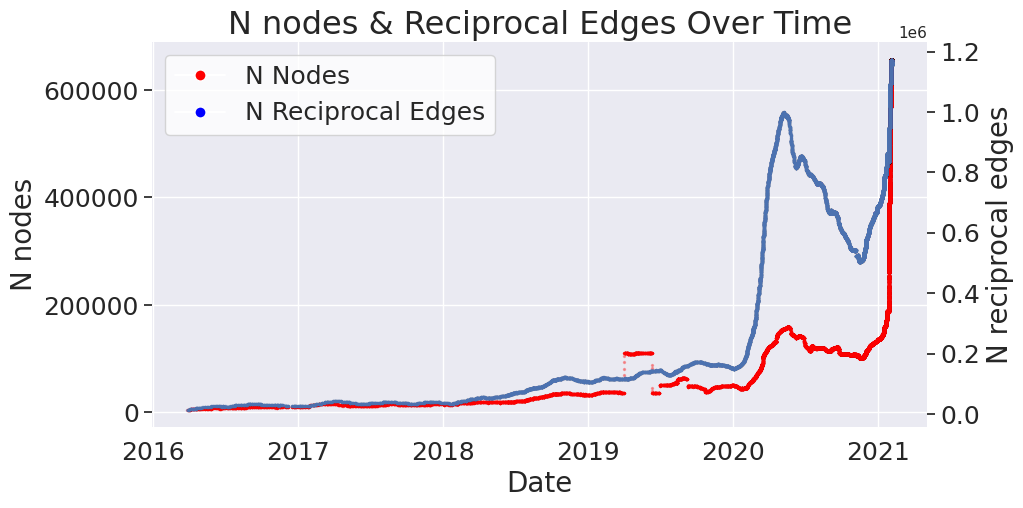

In [4]:
# twin y-axis 

sns.set_theme(style="darkgrid")
fig, ax1 = plt.subplots(figsize=(10,5))
sns.set_theme(style="white")

ax2 = ax1.twinx()
ax1.scatter(df.date,df.N_nodes,alpha=0.3,color='red',s=2,label='N nodes')
ax2.scatter(df.date,df.N_rec,alpha=0.3,s=2,label='reciprocal edges (%)')
ax1.set_xlabel('Date',fontsize=20)
ax1.set_ylabel('N nodes',fontsize=20)
ax2.set_ylabel('N reciprocal edges',fontsize=20)
plt.title('N nodes & Reciprocal Edges Over Time',fontsize=23)
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)

custom_scatter = [plt.Line2D([0], [0], marker='o', color='w', label='N nodes',markerfacecolor='red', markersize=8),
                    plt.Line2D([0], [0], marker='o', color='w', label='N reciprocal edges',markerfacecolor='blue', markersize=8)]
plt.legend(custom_scatter, ['N Nodes', 'N Reciprocal Edges'],fontsize=18)
sns.despine(left=True, bottom=True)
plt.show()
sns.set_theme(style="darkgrid")

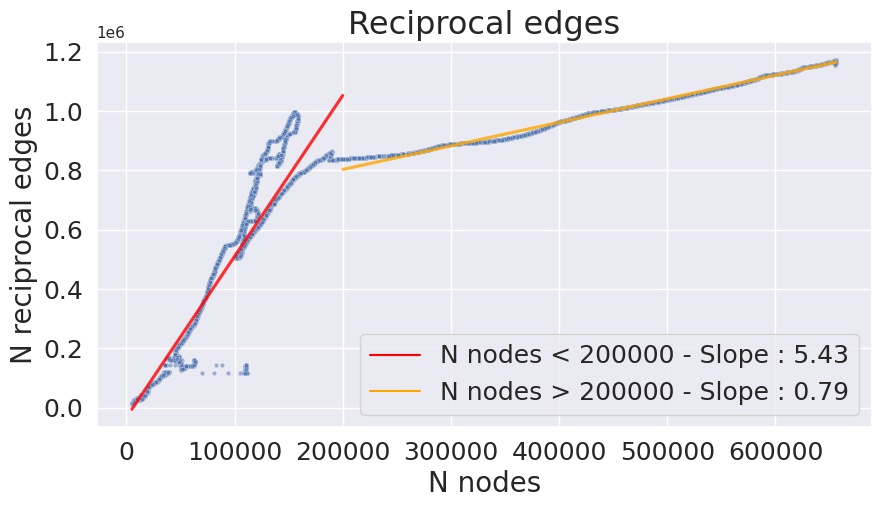

In [10]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='N_nodes',y='N_rec',data=df,alpha=0.5,s=10)

df_reg = df[df.N_nodes<200000]
sns.regplot(x='N_nodes',y='N_rec',data=df_reg,scatter=False,color='red',line_kws={'alpha':0.8})
slope1=LinearRegression().fit(df_reg['N_nodes'].values.reshape(-1,1), df_reg['N_rec'].values.reshape(-1,1)).coef_
slope1=str(round(slope1[0][0],2))

df_reg = df[df.N_nodes>200000]
sns.regplot(x='N_nodes',y='N_rec',data=df_reg,scatter=False,color='orange',line_kws={'alpha':0.8})
slope2=LinearRegression().fit(df_reg['N_nodes'].values.reshape(-1,1), df_reg['N_rec'].values.reshape(-1,1)).coef_
slope2=str(round(slope2[0][0],2))

# custom legend
custom_scatter = [plt.Line2D([0], [0], color='red', label='slope < 200000',markerfacecolor='red', markersize=8),
                    plt.Line2D([0], [0], color='orange', label='slope > 200000',markerfacecolor='orange', markersize=8)]
plt.legend(custom_scatter, ['N nodes < 200000 - Slope : '+slope1, 'N nodes > 200000 - Slope : '+slope2],fontsize=18)

plt.xlabel('N nodes',fontsize=20)
plt.ylabel('N reciprocal edges',fontsize=20)
plt.title('Reciprocal edges',fontsize=23)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

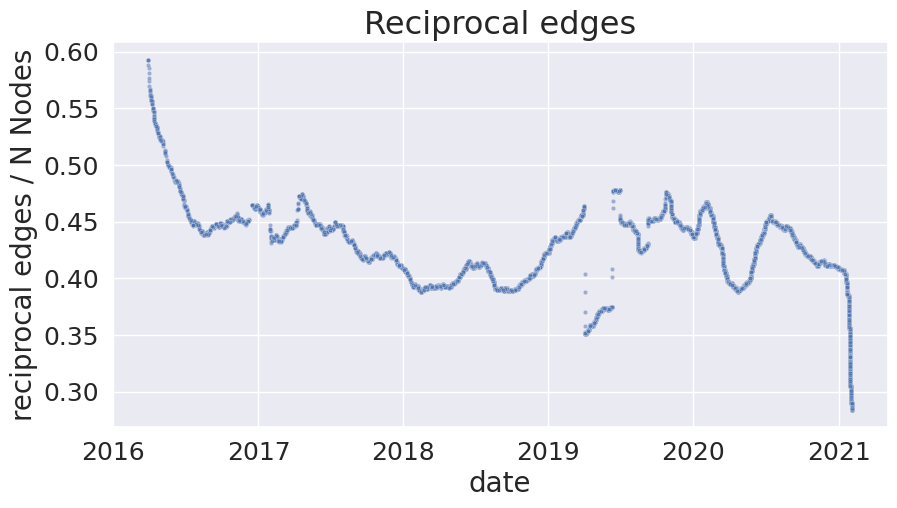

In [96]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='date',y='frac_rec',data=df,alpha=0.5,s=10)
plt.xlabel('date',fontsize=20)
plt.ylabel('reciprocal edges / N Nodes',fontsize=20)
plt.title('Reciprocal edges',fontsize=23)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# Mentions

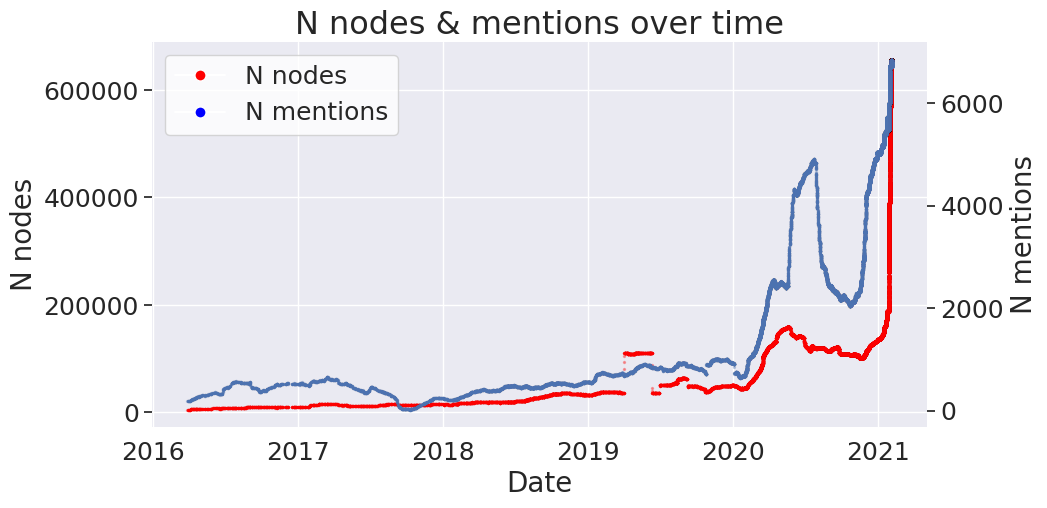

In [92]:
# twin y-axis 
sns.set_theme(style="darkgrid")
fig, ax1 = plt.subplots(figsize=(10,5))
sns.set_theme(style="white")
ax2 = ax1.twinx()
ax1.scatter(df.date,df.N_nodes,alpha=0.3,color='red',s=2)
ax2.scatter(df.date,df.sum_mentions,alpha=0.3,s=2)
ax1.set_xlabel('Date',fontsize=20)
ax1.set_ylabel('N nodes',fontsize=20)
ax2.set_ylabel('N mentions',fontsize=20)
plt.title('N nodes & mentions over time',fontsize=23)
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)
custom_scatter = [plt.Line2D([0], [0], marker='o', color='w', label='N nodes',markerfacecolor='red', markersize=8),
                    plt.Line2D([0], [0], marker='o', color='w', label='N mentions',markerfacecolor='blue', markersize=8)]
plt.legend(custom_scatter, ['N nodes', 'N mentions'],fontsize=18)
sns.despine(left=True, bottom=True)
plt.show()
sns.set_theme(style="darkgrid")

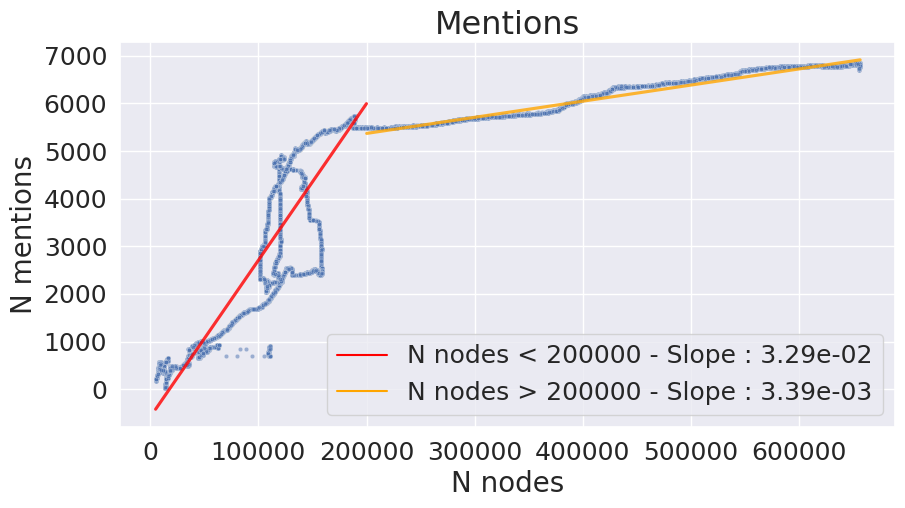

In [11]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='N_nodes',y='sum_mentions',data=df,alpha=0.5,s=10)

df_reg = df[df.N_nodes>200000]
sns.regplot(x='N_nodes',y='sum_mentions',data=df_reg,scatter=False,color='orange',line_kws={'alpha':0.8})
slope2=LinearRegression().fit(df_reg['N_nodes'].values.reshape(-1,1), df_reg['sum_mentions'].values.reshape(-1,1)).coef_
slope2='{:.2e}'.format(slope2[0][0])

df_reg = df[df.N_nodes<200000]
sns.regplot(x='N_nodes',y='sum_mentions',data=df_reg,scatter=False,color='red',line_kws={'alpha':0.8})
slope1=LinearRegression().fit(df_reg['N_nodes'].values.reshape(-1,1), df_reg['sum_mentions'].values.reshape(-1,1)).coef_
slope1='{:.2e}'.format(slope1[0][0])

custom_scatter = [plt.Line2D([0], [0], color='red', label='slope < 200000',markerfacecolor='red', markersize=8),
                    plt.Line2D([0], [0], color='orange', label='slope > 200000',markerfacecolor='orange', markersize=8)]
plt.legend(custom_scatter, ['N nodes < 200000 - Slope : '+slope1, 'N nodes > 200000 - Slope : '+slope2],fontsize=18)

plt.xlabel('N nodes',fontsize=20)
plt.ylabel('N mentions',fontsize=20)
plt.title('Mentions',fontsize=23)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

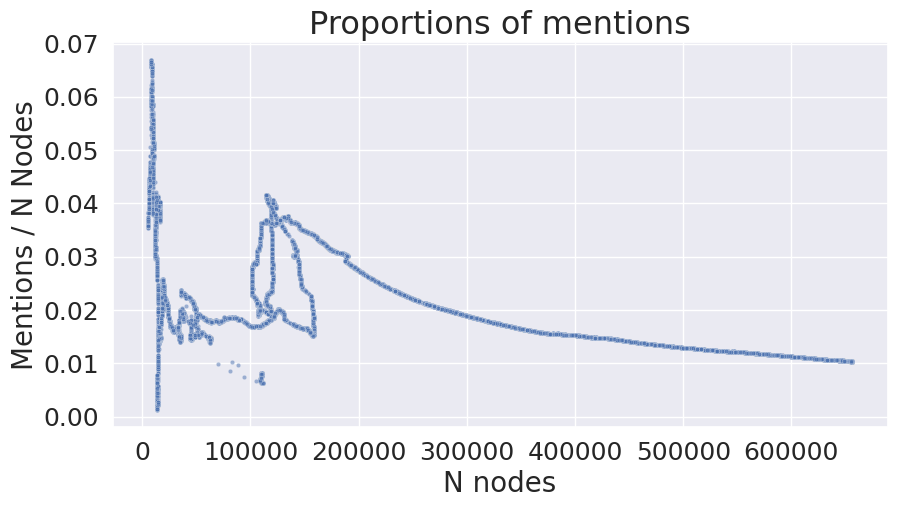

In [80]:
df['mentions_frac'] = df['sum_mentions']/df['N_nodes']

plt.figure(figsize=(10,5))
sns.scatterplot(x='N_nodes',y='mentions_frac',data=df,alpha=0.5,s=10)
plt.xlabel('N nodes',fontsize=20)
plt.ylabel('Mentions / N Nodes',fontsize=20)
plt.title('Proportions of mentions',fontsize=23)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()